In [1]:
## read the data
import scipy.io
data = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')

In [2]:
fs =125 # Sample rate in Hz

import scipy.signal as signal
def chebyshev_filter(signal):
    # Define the filter order and cutoff frequency
    order = 4
    cutoff_freq = 20  # Cutoff frequency in Hz
    # Create the Chebyshev low-pass filter
    b, a = signal.cheby1(order, 0.5, cutoff_freq / (fs / 2), 'low', analog=False)
    return signal.lfilter(b, a, signal)

from scipy.signal import butter, filtfilt
def butter_filter(signal):
    fs = 125  # Sample rate
    cutoff = 5  # Cutoff frequency in Hz
    # Design the Butterworth low-pass filter
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    b, a = butter(4, cutoff_norm, btype='low')
    return filtfilt(b, a, signal)

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg
def standard_signal(bp): 
    return (bp - np.mean(bp)) / np.std(bp)
def inverse_standard_signal(bp_ori, bp_est):
    mean = np.mean(bp_ori)
    std = np.std(bp_ori)
    return (bp_est * std) + mean

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp_segment(ppg_signal, bp_signal1, bp_signal2, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ppg_peaks, _ = find_peaks(ppg_signal, height=0.5)  # Adjust the height threshold as needed
    bp_peaks, _ = find_peaks(bp_signal1, height=0.4)
    ecg_peaks, _ = find_peaks(ecg_signal, height=0.65)
    #print(f'ppg peaks: {len(ppg_peaks)} {ppg_peaks}')
    #print(f'ecg peaks: {len(ecg_peaks)} {ecg_peaks}')

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal1[distance_ppgbp:]
        bp_ori_aligned = bp_signal2[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    ppg_aligned = ppg_aligned[:min_len]
    bp_aligned = bp_aligned[:min_len]
    bp_ori_aligned = bp_ori_aligned[:min_len]
    ecg_aligned = ecg_signal[:min_len]
    #print(ecg_aligned)
    ppg_segmented = ppg_aligned[:first_ecg_peak-5]
    bp_segmented = bp_aligned[:first_ecg_peak-5]
    bp_ori_segmented = bp_ori_aligned[:first_ecg_peak-5]
    ecg_segmented = ecg_aligned[:first_ecg_peak-5]

    for ecgi in range(len(ecg_peaks)-1):
        one_ppg_peak, _ = find_peaks(ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5], height=0.5)
        #print(ecg_peaks[ecgi], one_ppg_peak)
        if len(one_ppg_peak) == 1:
            ppg_segmented = np.concatenate((ppg_segmented, ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_segmented = np.concatenate((bp_segmented, bp_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_ori_segmented = np.concatenate((bp_ori_segmented, bp_ori_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            ecg_segmented = np.concatenate((ecg_segmented, ecg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))

    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal1, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal1[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_segmented, label='PPG')
        plt.plot(bp_segmented, label='BP')
        plt.plot(ecg_segmented, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented

import numpy as np
def get_feautres(ppg_signal, bp_signal1, bp_signal2, ecg_signal):
    ori_ecg_peaks, _ = find_peaks(ecg_signal)
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    #print(f'r_peaks: {len(r_peaks)} {r_peaks}')
    r_peak_amplitudes = (ecg_signal[r_peaks]).tolist()
    r_peak_amplitudes = r_peak_amplitudes[:-1]
    #print(f'r_peak_amplitudes: {len(r_peak_amplitudes)} {r_peak_amplitudes}')
    r_peak_intervals = (np.diff(r_peaks) / fs).tolist()
    #print(f'r_peak_intervals: {len(r_peak_intervals)} {r_peak_intervals}')
    # calculate low peak, s-peak
    low_peak_amplitudes, r_to_low_peak_amplitudes, s_peak_amplitudes= [], [], []
    low_peaks, s_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        low_peak_amplitude = np.min(ecg_signal[r_peak:next_r_peak])
        r_to_low_peak_amplitude = ecg_signal[r_peak]-low_peak_amplitude
        low_peak_amplitudes.append(low_peak_amplitude)
        r_to_low_peak_amplitudes.append(r_to_low_peak_amplitude)
        low_peak = r_peak + np.argmin(ecg_signal[r_peak:next_r_peak])
        low_peaks.append(low_peak)
        s_peak_amplitude = np.min(ecg_signal[r_peak:low_peak])
        s_peak_amplitudes.append(s_peak_amplitude)
        s_peak = r_peak + np.argmin(ecg_signal[r_peak:low_peak])
        s_peaks.append(s_peak)   
    #print(f'low peaks: {len(low_peaks)} {low_peaks}')  
    #print(f's peaks: {len(s_peaks)} {s_peaks}')  
    # T-Wave Amplitude Calculation
    r_peaks = np.insert(r_peaks, 0, 0) #the first t-peak is before the R-peak
    t_wave_amplitudes, q_wave_amplitudes = [], []
    t_peaks, q_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        t_wave_amplitude = np.max(ecg_signal[r_peak:next_r_peak])
        t_wave_amplitudes.append(t_wave_amplitude)
        t_peak = r_peak + np.argmax(ecg_signal[r_peak:next_r_peak])
        t_peaks.append(t_peak)
        q_wave_amplitude = np.min(ecg_signal[t_peak:next_r_peak])
        q_wave_amplitudes.append(q_wave_amplitude)
        q_peak = r_peak + np.argmin(ecg_signal[t_peak:next_r_peak])
        q_peaks.append(q_peak)

    t_wave_amplitudes = t_wave_amplitudes[:-1]
    q_wave_amplitudes = q_wave_amplitudes[:-1]
    #print(f't peaks: {len(t_peaks)} {t_peaks}')  
    #print(f'q peaks: {len(q_peaks)} {q_peaks}')  
    
    # QRS interval
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    qrs_intervals = []
    for i in range(len(r_peaks)-1):
        qrs_interval = (ecg_signal[s_peaks[i]] - ecg_signal[q_peaks[i]]) / fs
        qrs_intervals.append(abs(qrs_interval))
    #print(f'qrs_intervals: {len(qrs_intervals)} {qrs_intervals}')  

    # get ppg features:
    ppg_pulses, bp_pulses, bp_ori_pulses = [], [], []
    for i in range(len(r_peaks)-1):
        ppg_pulse = ppg_signal[r_peaks[i]:r_peaks[i+1]]
        bp_pulse = bp_signal1[r_peaks[i]:r_peaks[i+1]]
        bp_ori_pulse = bp_signal2[r_peaks[i]:r_peaks[i+1]]
        ppg_pulses.append(ppg_pulse)
        bp_pulses.append(bp_pulse)
        bp_ori_pulses.append(bp_ori_pulse)
    #print(f'bp pulses: {bp_pulses}')
    ppg_pulse_amplitude = [np.max(pulse) - np.min(pulse) for pulse in ppg_pulses]
    ppg_pulse_width = [pulse.shape[0]/fs for pulse in ppg_pulses]
    ppg_high_to_low_interval = [np.argmin(pulse)/fs for pulse in ppg_pulses]
    ppg_slope_change_std = [np.std(np.diff(pulse)) for pulse in ppg_pulses]

    sbp = [np.max(pulse) for pulse in bp_pulses]
    dbp = [np.min(pulse) for pulse in bp_pulses]
    sbp_ori = [np.max(pulse) for pulse in bp_ori_pulses]
    dbp_ori = [np.min(pulse) for pulse in bp_ori_pulses]
    
    return sbp, dbp, sbp_ori, dbp_ori, ppg_pulse_amplitude, ppg_pulse_width, ppg_high_to_low_interval, ppg_slope_change_std, t_wave_amplitudes, q_wave_amplitudes, r_peak_amplitudes, s_peak_amplitudes, low_peak_amplitudes, qrs_intervals, r_to_low_peak_amplitudes, r_peak_intervals

import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

In [3]:
patients = [0, 1, 2, 3, 4, 6, 14, 15, 16, 18, 24, 35, 36, 37, 39, 40, 41, 46, 64, 66, 67, 73, 79, 80, 81, 82, 86, 87, 88, 89, 93, 94, 95, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 115, 116, 117, 118, 120, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 141, 144, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 182, 184, 186, 188, 189, 192, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 272, 273, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 295, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310, 311, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 380, 391, 393, 394, 395, 397, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 413, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 429, 430, 431, 432, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 459, 460, 462, 463, 464, 465, 466, 470, 471, 472, 475, 480, 481, 482, 483, 484, 486, 487, 488, 490, 491, 492, 496, 497, 498, 499, 500, 502, 503, 504, 505, 507, 508, 509, 510, 512, 514, 515, 516, 520, 524, 527, 528, 529, 530, 531, 532, 533, 535, 537, 538, 539, 543, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 564, 565, 570, 576, 577, 578, 582, 590, 592, 593, 597, 599, 600, 602, 603, 604, 606, 607, 609, 612, 625, 626, 627, 628, 629, 630, 633, 634, 635, 639, 640, 641, 644, 646, 648, 653, 655, 656, 657, 658, 662, 670, 673, 674, 676, 677, 681, 682, 683, 685, 686, 687, 688, 689, 692, 693, 695, 696, 697, 698, 700, 703, 704, 705, 706, 707, 708, 709, 711, 712, 717, 719, 720, 721, 722, 723, 724, 725, 727, 729, 730, 731, 733, 734, 735, 736, 737, 741, 743, 744, 748, 749, 753, 754, 755, 756, 759, 774, 775, 776, 777, 780, 781, 783, 784, 785, 786, 787, 790, 791, 792, 794, 799, 800, 801, 802, 803, 805, 807, 808, 809, 810, 813, 820, 821, 822, 823, 828, 829, 830, 843, 845, 847, 868, 869, 922, 923, 947, 948, 949, 951, 952, 957, 959, 960, 962, 972, 975, 981, 989]

In [4]:
# get all patient dataset
sbp500 = []
dbp500 = []
sbp_ori500 = []
dbp_ori500 = []
features500 = []
for patient in patients:
    patient_data = data['p'][0,patient]
    if len(patient_data[0]) >= 25000:
        ppg_ori = patient_data[0]
        bp_ori = patient_data[1]
        ecg_ori = patient_data[2]
        ecg_detrened = straighten_ecg(ecg_ori)
        ppg_normalized = normalize_sinal(ppg_ori)
        bp_standarded = bp_ori / 250
        ecg_normalized = normalize_sinal(ecg_detrened)
        ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented = align_ppgbp_segment(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
        bps_features = get_feautres(ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented)
        sbp = np.array(bps_features[0])
        dbp = np.array(bps_features[1])
        sbp_ori = np.array(bps_features[2])
        dbp_ori = np.array(bps_features[3])
        features = np.array(bps_features[4:])
        sbp500.append(sbp)
        dbp500.append(dbp)
        sbp_ori500.append(sbp_ori)
        dbp_ori500.append(dbp_ori)
        features500.append(features)
        print(patient)
len(sbp_ori500)   

0
1
2
3
4
6
14
15
16
18
24
35
36
37
39
40
41
46
64
66
67
73
79
80
81
82
86
87
88
89
93
94
95
98
99
100
101
102
103
104
105
108
109
110
111
115
116
117
118
120
124
125
126
127
128
129
130
131
132
133
134
141
144
149
150
151
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
179
182
184
186
188
189
192
195
196
197
198
199
200
201
202
203
204
206
207
208
209
211
212
213
214
215
216
217
218
219
220
221
222
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
245
246
247
248
249
251
252
253
254
255
256
257
259
260
261
262
263
264
265
266
267
268
269
272
273
277
278
279
281
282
283
284
285
286
287
288
289
290
295
297
298
299
300
301
302
303
304
305
306
307
309
310
311
313
314
315
316
317
318
319
320
321
323
324
327
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
352
353
354
355
356
357
358
359
360
361
363
364
365
366
367
368
369
370
371
372
373
374
377
380
391
393
394
395
397
399
400
4

509

In [5]:
## split train and test dataset
train_sbp = sbp500[:400]
train_dbp = dbp500[:400]
train_sbp_ori = sbp_ori500[:400]
train_dbp_ori = dbp_ori500[:400]
train_features = features500[:400]
test_sbp = []
test_dbp = []
test_sbp_ori = []
test_dbp_ori = []
test_features = []

for i in range(len(sbp500)-400):
    train_sbp.append(sbp500[i+400][:int(0.2*len(sbp500[i+400]))])
    train_dbp.append(dbp500[i+400][:int(0.2*len(dbp500[i+400]))])
    train_sbp_ori.append(sbp_ori500[i+400][:int(0.2*len(sbp_ori500[i+400]))])
    train_dbp_ori.append(dbp_ori500[i+400][:int(0.2*len(dbp_ori500[i+400]))])
    train_features.append(features500[i+400][:,:int(0.2*(features500[i+400].shape[1]))])
    test_sbp.append(sbp500[i+400][int(0.2*len(sbp500[i+400])):])
    test_dbp.append(dbp500[i+400][int(0.2*len(dbp500[i+400])):])
    test_sbp_ori.append(sbp_ori500[i+400][int(0.2*len(sbp_ori500[i+400])):])
    test_dbp_ori.append(dbp_ori500[i+400][int(0.2*len(dbp_ori500[i+400])):])
    test_features.append(features500[i+400][:,int(0.2*(features500[i+400].shape[1])):])

merged_train_sbp = np.concatenate(train_sbp, axis=0)
merged_train_dbp = np.concatenate(train_dbp, axis=0)
merged_train_sbp_ori = np.concatenate(train_sbp_ori, axis=0)
merged_train_dbp_ori = np.concatenate(train_dbp_ori, axis=0)
merged_train_features = np.concatenate(train_features, axis=1)
merged_train_features = merged_train_features.T

In [6]:
len(merged_train_features)

274358

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)  

def bp_lstm_model(train_features_df, train_bp):
    time_steps = 10
    X_train, y_train_ori = create_sequences(train_features_df, pd.DataFrame(train_bp), time_steps)
    y_train = np.around(((y_train_ori - y_train_ori.min()) / (y_train_ori.max() - y_train_ori.min())), decimals=4)
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 12)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=200, verbose=1)
    return model

In [7]:
import torch
batch_size = 10
num_batches = len(merged_train_features) // batch_size
# Create an empty list to store the tensors
X_train_noshape_batches = []
sbp_train_noshape_batches = []
dbp_train_noshape_batches = []
# Process the data in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    X_train_noshape_batch = torch.tensor(merged_train_features[start_idx:end_idx])
    X_train_noshape_batches.append(X_train_noshape_batch)
    sbp_train_noshape_batch = torch.tensor(merged_train_sbp[start_idx:end_idx])
    sbp_train_noshape_batches.append(sbp_train_noshape_batch)
    dbp_train_noshape_batch = torch.tensor(merged_train_dbp[start_idx:end_idx])
    dbp_train_noshape_batches.append(dbp_train_noshape_batch)

# Concatenate the batches into a single tensor
X_train_noshape = torch.cat(X_train_noshape_batches, dim=0)
sbp_train_noshape = torch.cat(sbp_train_noshape_batches, dim=0)
dbp_train_noshape = torch.cat(dbp_train_noshape_batches, dim=0)
time_step = 4
train_num_samples = X_train_noshape.shape[0] - time_step + 1

In [8]:
X_train_noshape.shape[0]

274350

In [9]:
train_num_samples

274347

In [18]:
X_train_batches = []
sbp_train_batches = []
dbp_train_batches = []
for i in range(num_batches):
    X_train_batch = torch.zeros((batch_size, time_step, X_train_noshape.shape[1]))
    X_train_batches.append(X_train_batch)
    sbp_train_batch = torch.zeros((batch_size, 1))
    sbp_train_batches.append(sbp_train_batch)
    dbp_train_batch = torch.zeros((batch_size, 1))
    dbp_train_batches.append(dbp_train_batch)
X_train = torch.cat(X_train_batches, dim=0)
X_train = X_train[:-(time_step-1)]
sbp_train = torch.cat(sbp_train_batches, dim=0)
sbp_train = sbp_train[:-(time_step-1)]
dbp_train = torch.cat(dbp_train_batches, dim=0)
dbp_train = dbp_train[:-(time_step-1)]
for i in range(train_num_samples):
    X_train[i] = X_train_noshape[i:i+time_step, :]
    sbp_train[i] = sbp_train_noshape[i+time_step-1]
    dbp_train[i] = dbp_train_noshape[i+time_step-1]

print(X_train.shape, sbp_train.shape)

In [24]:
import torch
import torch.nn as nn
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output

# Create an instance of the LSTM model
lstm_model_sbp = LSTMModel(input_size = 12, hidden_size = 64, output_size = 1)
lstm_model_dbp = LSTMModel(input_size = 12, hidden_size = 64, output_size = 1)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model_sbp.parameters(), lr=0.001)
# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs_sbp = lstm_model_sbp(X_train)   
    loss_sbp = criterion(outputs_sbp, sbp_train)
    loss_sbp.backward()
    outputs_dbp = lstm_model_sbp(X_train)   
    loss_dbp = criterion(outputs_dbp, dbp_train)
    loss_dbp.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_sbp.item()}, Loss: {loss_dbp.item()}")


: 

: 

In [ ]:
## LSTM-GRU model
class LSTMGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # Set initial hidden and cell states for LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        # GRU forward pass
        gru_out, _ = self.gru(lstm_out)
        # Get the final output from the last time step of GRU
        output = gru_out[:, -1, :]
        # Fully connected layer
        output = self.fc(output)
        return output
lstmgru_model_sbp = LSTMGRUModel(input_size =12, hidden_size=64, num_layers=2, output_size=1)
lstmgru_model_dbp = LSTMGRUModel(input_size =12, hidden_size=64, num_layers=2, output_size=1)
# Define the loss function and optimizer
criterion_sbp = nn.MSELoss()
optimizer_sbp = torch.optim.Adam(lstmgru_model_sbp.parameters(), lr=0.001)
num_epochs = 2600
# Training loop
for epoch in range(num_epochs):
    lstmgru_model_sbp.train()
    optimizer_sbp.zero_grad()
    sbp_outputs = lstmgru_model_sbp(X_train)
    loss_sbp = criterion_sbp(sbp_outputs, sbp_train)
    loss_sbp.backward()
    optimizer_sbp.step()
criterion_dbp = nn.MSELoss()
optimizer_dbp = torch.optim.Adam(lstmgru_model_dbp.parameters(), lr=0.001)
num_epochs = 2600
# Training loop
for epoch in range(num_epochs):
    lstmgru_model_dbp.train()
    optimizer_dbp.zero_grad()
    dbp_outputs = lstmgru_model_dbp(X_train)
    loss_dbp = criterion_dbp(dbp_outputs, dbp_train)
    loss_dbp.backward()
    optimizer_dbp.step()

KeyboardInterrupt: 

Test Loss: 0.07598670572042465
Test Loss: 0.13121065497398376
MAE: 90.52612
RMSE: 68.914215


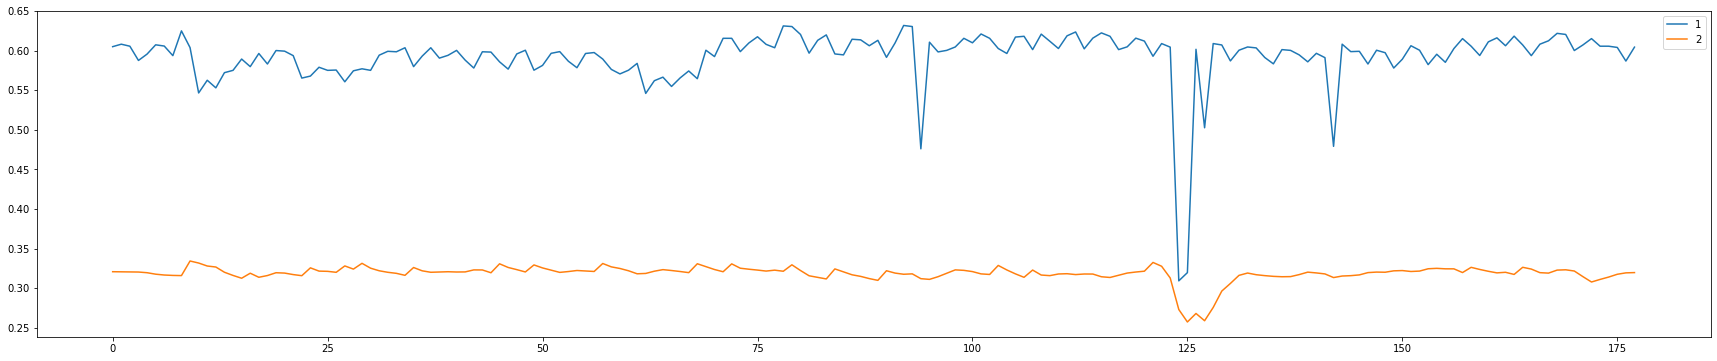

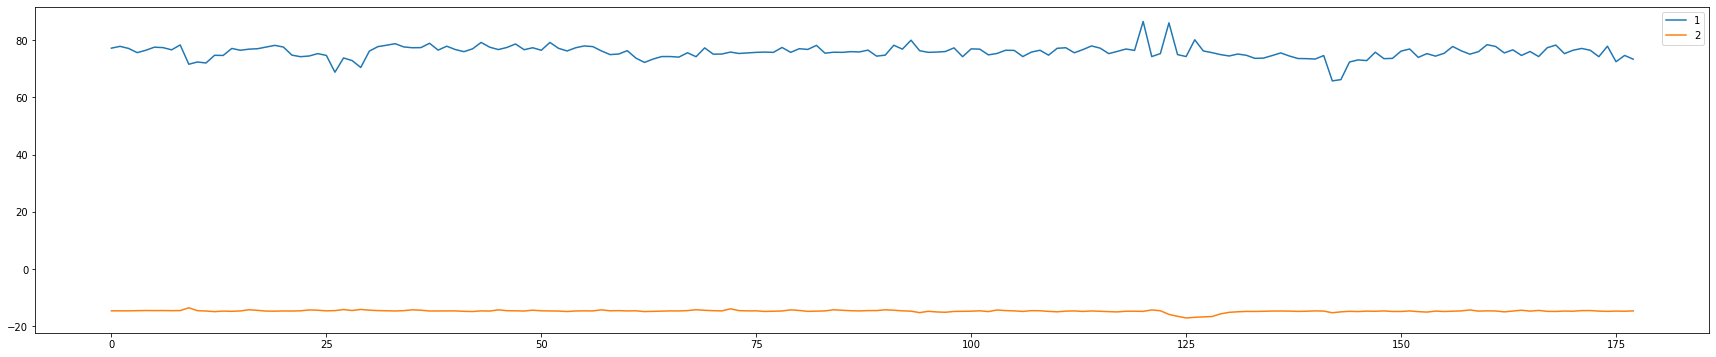

In [ ]:
for i in range(1):#len(test_sbp)
    X_test_noshape = torch.tensor(test_features[i])
    sbp_test_noshape = torch.tensor(test_sbp[i])
    sbp_test_ori_noshape = torch.tensor(test_sbp_ori[i])
    dbp_test_noshape = torch.tensor(test_dbp[i])
    dbp_test_ori_noshape = torch.tensor(test_dbp_ori[i])
    test_num_samples = X_test_noshape.shape[1] - time_step + 1
    X_test = torch.zeros((test_num_samples, time_step, X_test_noshape.shape[0]))
    sbp_test = torch.zeros((test_num_samples, 1))
    sbp_test_ori = torch.zeros((test_num_samples, 1))
    dbp_test = torch.zeros((test_num_samples, 1))
    dbp_test_ori = torch.zeros((test_num_samples, 1))
    for i in range(test_num_samples):
        X_test[i] = X_test_noshape[:, i:i+time_step].T
        sbp_test[i] = sbp_test_noshape[i+time_step-1]
        sbp_test_ori[i] = sbp_test_ori_noshape[i+time_step-1]
        dbp_test[i] = dbp_test_noshape[i+time_step-1]
        dbp_test_ori[i] = dbp_test_ori_noshape[i+time_step-1]
    
    lstm_model_sbp.eval()
    with torch.no_grad():
        sbp_pred_lstm = lstm_model_sbp(X_test)
        sbp_pred_ori_lstm = sbp_pred_lstm * 250
        test_loss_sbp_lstm = criterion(sbp_pred_lstm, sbp_test)
        print(f"Test Loss: {test_loss_sbp_lstm.item()}")
    mae_sbp_lstm = mean_absolute_error(np.array(sbp_test_ori), np.array(sbp_pred_ori_lstm))
    rmse_sbp_lstm = np.sqrt(mean_squared_error(np.array(sbp_test_ori), np.array(sbp_pred_ori_lstm)))
    lstm_model_dbp.eval()
    with torch.no_grad():
        dbp_pred_lstm = lstm_model_dbp(X_test)
        dbp_pred_ori_lstm = dbp_pred_lstm * 250
        test_loss_dbp_lstm = criterion(dbp_pred_lstm, dbp_test)
        print(f"Test Loss: {test_loss_dbp_lstm.item()}")
    mae_dbp_lstm = mean_absolute_error(np.array(dbp_test_ori), np.array(dbp_pred_ori_lstm))
    rmse_dbp_lstm = np.sqrt(mean_squared_error(np.array(dbp_test_ori), np.array(dbp_pred_ori_lstm)))
    print("MAE:", mae_dbp_lstm)
    print("RMSE:", rmse_sbp_lstm)
    show_two(sbp_test, sbp_pred_lstm)
    show_two(dbp_test_ori, dbp_pred_ori_lstm)
    # Evaluation lstmgru
    lstmgru_model_sbp.eval()
    with torch.no_grad():
        sbp_pred_lstmgru = lstmgru_model_sbp(X_test)
        sbp_pred_ori_lstmgru = sbp_pred_lstmgru * 250
        test_loss_sbp_lstmgru = criterion_sbp(sbp_pred_lstmgru, sbp_test)
        print(f"Test Loss: {test_loss_sbp_lstmgru.item()}")
    mae_sbp_lstmgru = mean_absolute_error(np.array(sbp_test_ori), np.array(sbp_pred_ori_lstmgru))
    rmse_sbp_lstmgru = np.sqrt(mean_squared_error(np.array(sbp_test_ori), np.array(sbp_pred_ori_lstmgru)))
    lstmgru_model_dbp.eval()
    with torch.no_grad():
        dbp_pred_lstmgru = lstmgru_model_dbp(X_test)
        dbp_pred_ori_lstmgru = dbp_pred_lstmgru * 250
        test_loss_dbp_lstmgru = criterion_dbp(dbp_pred_lstmgru, dbp_test)
        print(f"Test Loss: {test_loss_dbp_lstmgru.item()}")
    mae_dbp_lstmgru = mean_absolute_error(np.array(dbp_test_ori), np.array(dbp_pred_ori_lstmgru))
    rmse_dbp_lstmgru = np.sqrt(mean_squared_error(np.array(dbp_test_ori), np.array(dbp_pred_ori_lstmgru)))
    print("MAE:", mae_sbp_lstmgru)
    print("RMSE:", rmse_dbp_lstmgru)
    show_two(sbp_test, sbp_pred_lstmgru)
    show_two(dbp_test_ori, dbp_pred_ori_lstmgru)